## 75.06/95.58 Organización de Datos: Trabajo Práctico 1
### Primer Cuatrimestre de 2020 



In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from gensim.parsing.preprocessing import STOPWORDS
import string
%matplotlib inline
import plotly.express as px

pd.set_option('mode.chained_assignment', None)
plt.rcParams['font.sans-serif'] = ['Source Han Sans TW', 'sans-serif']

tweets = pd.read_csv('train.csv') 
tweets.tail()

,id,keyword,location,text,target
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1
7612,10873,NaN,NaN,The Latest: More Homes Razed by Northern Calif...,1


In [2]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [3]:
tweets['text'].describe()

count                                                  7613
unique                                                 7503
top       11-Year-Old Boy Charged With Manslaughter of T...
freq                                                     10
Name: text, dtype: object

In [4]:
tweets['location'].describe()

count     5080
unique    3341
top        USA
freq       104
Name: location, dtype: object

In [5]:
tweets['keyword'].describe()

count           7552
unique           221
top       fatalities
freq              45
Name: keyword, dtype: object

In [6]:
duplicates = tweets.duplicated(subset = 'text', keep = False)
duplicates.value_counts()

False    7434
True      179
dtype: int64

In [7]:
tweets.drop_duplicates(subset = 'text', keep = False, inplace = True)
tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7434 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7434 non-null   int64 
 1   keyword   7378 non-null   object
 2   location  4982 non-null   object
 3   text      7434 non-null   object
 4   target    7434 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 348.5+ KB


### Cantidad de reales vs falsos

In [8]:
tweets['target'].value_counts(normalize=True)

0    0.576271
1    0.423729
Name: target, dtype: float64

### Top 50 desastres comentados en los tweets

In [9]:
desastres = tweets.groupby("keyword").agg({"target":["count","mean"]})
level0 = desastres.columns.get_level_values(0)
level1 = desastres.columns.get_level_values(1)
desastres.columns = level0 + "_" + level1
desastres.sort_values(by="target_count",ascending = False,inplace = True)
desastres = desastres.head(50) #TOP 50

[]

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


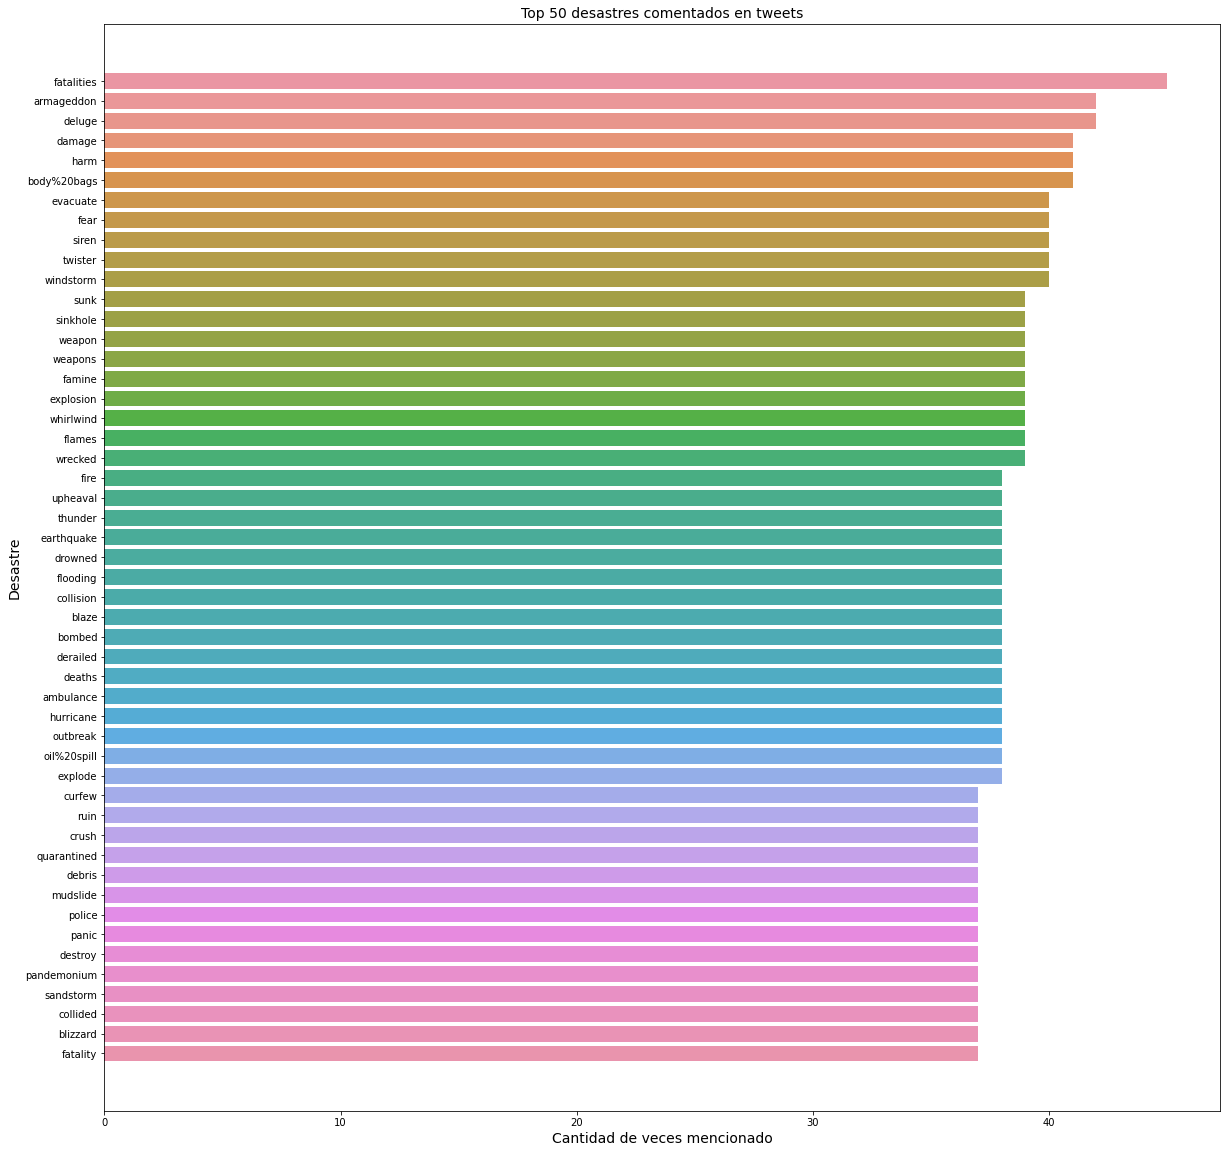

In [10]:
fig = plt.figure(figsize=(20,20))
grafico = sns.barplot(data = desastres,x = "target_count",y = desastres.index)
grafico.set_title("Top 50 desastres comentados en tweets",fontsize = 14)
grafico.set_xlabel("Cantidad de veces mencionado",fontsize = 14)
grafico.set_ylabel("Desastre",fontsize = 14)
grafico.plot()

### Top 50 desastres comentados en los tweets

In [11]:
desastres = tweets.groupby("keyword").agg({"target":["count","mean"]}).copy()
level0 = desastres.columns.get_level_values(0)
level1 = desastres.columns.get_level_values(1)
desastres.columns = level0 + "_" + level1
desastres.sort_values(by="target_count",ascending = False,inplace = True)
desastres = desastres.head(50) #TOP 50

[]

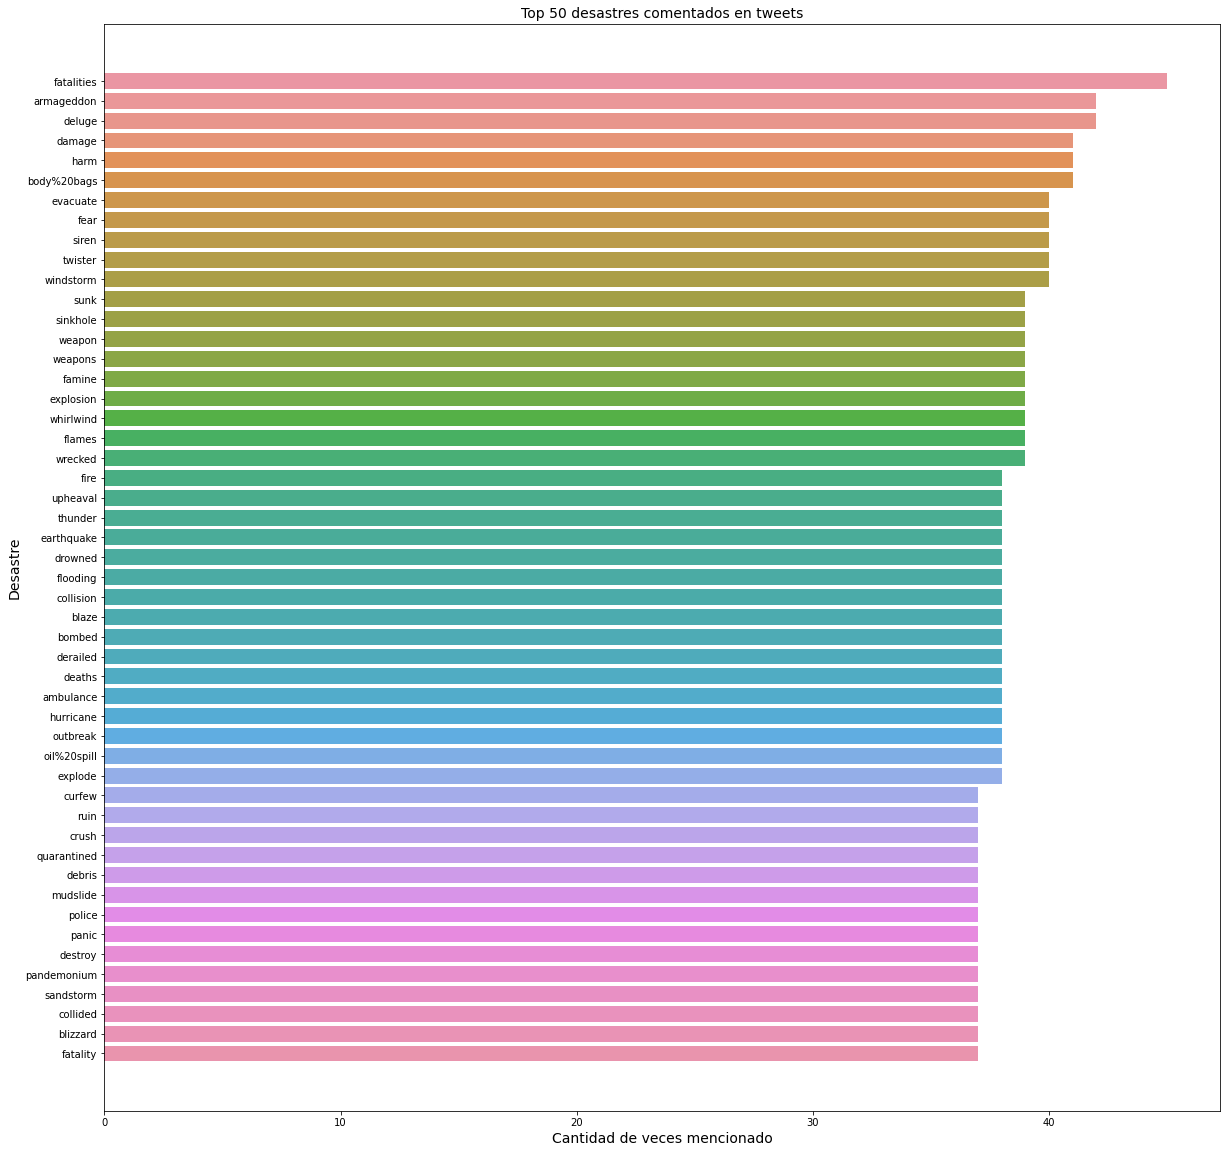

In [12]:
fig = plt.figure(figsize=(20,20))
grafico = sns.barplot(data = desastres,x = "target_count",y = desastres.index)
grafico.set_title("Top 50 desastres comentados en tweets",fontsize = 14)
grafico.set_xlabel("Cantidad de veces mencionado",fontsize = 14)
grafico.set_ylabel("Desastre",fontsize = 14)
grafico.plot()

### Top Hastags más usados

In [13]:
tweets_with_ht = tweets.loc[tweets['text'].str.contains('#')]

In [14]:
tweets_with_ht['hashtags'] = tweets_with_ht['text'].str.findall(r'#[^?\s].*?(?=\s|$)')
tweets_hashtags = tweets_with_ht.explode('hashtags')
tweets_hashtags.dropna(subset = ["hashtags"],inplace = True)
tweets_hashtags["hashtags"] = tweets_hashtags["hashtags"].str.lower()

In [15]:
tweets_hashtags.head()

,id,keyword,location,text,target,hashtags
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,#earthquake
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,#wildfires
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,#alaska
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,#wildfires
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1,#rockyfire


In [16]:
hashtags_top = tweets_hashtags.groupby('hashtags').agg({'target':['count', 'mean']})
hashtags_top.sort_values(by=("target", "count"), ascending = False, inplace = True)
hashtags_top[("target", "mean")] = (hashtags_top[("target", "mean")] * 100).round()
hashtags_top = hashtags_top.head(50).reset_index()
hashtags_top.head()

hashtags target       
               count   mean
0       #news     73   73.0
1   #prebreak     30   43.0
2        #hot     30   43.0
3       #best     30   43.0
4  #hiroshima     21  100.0

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


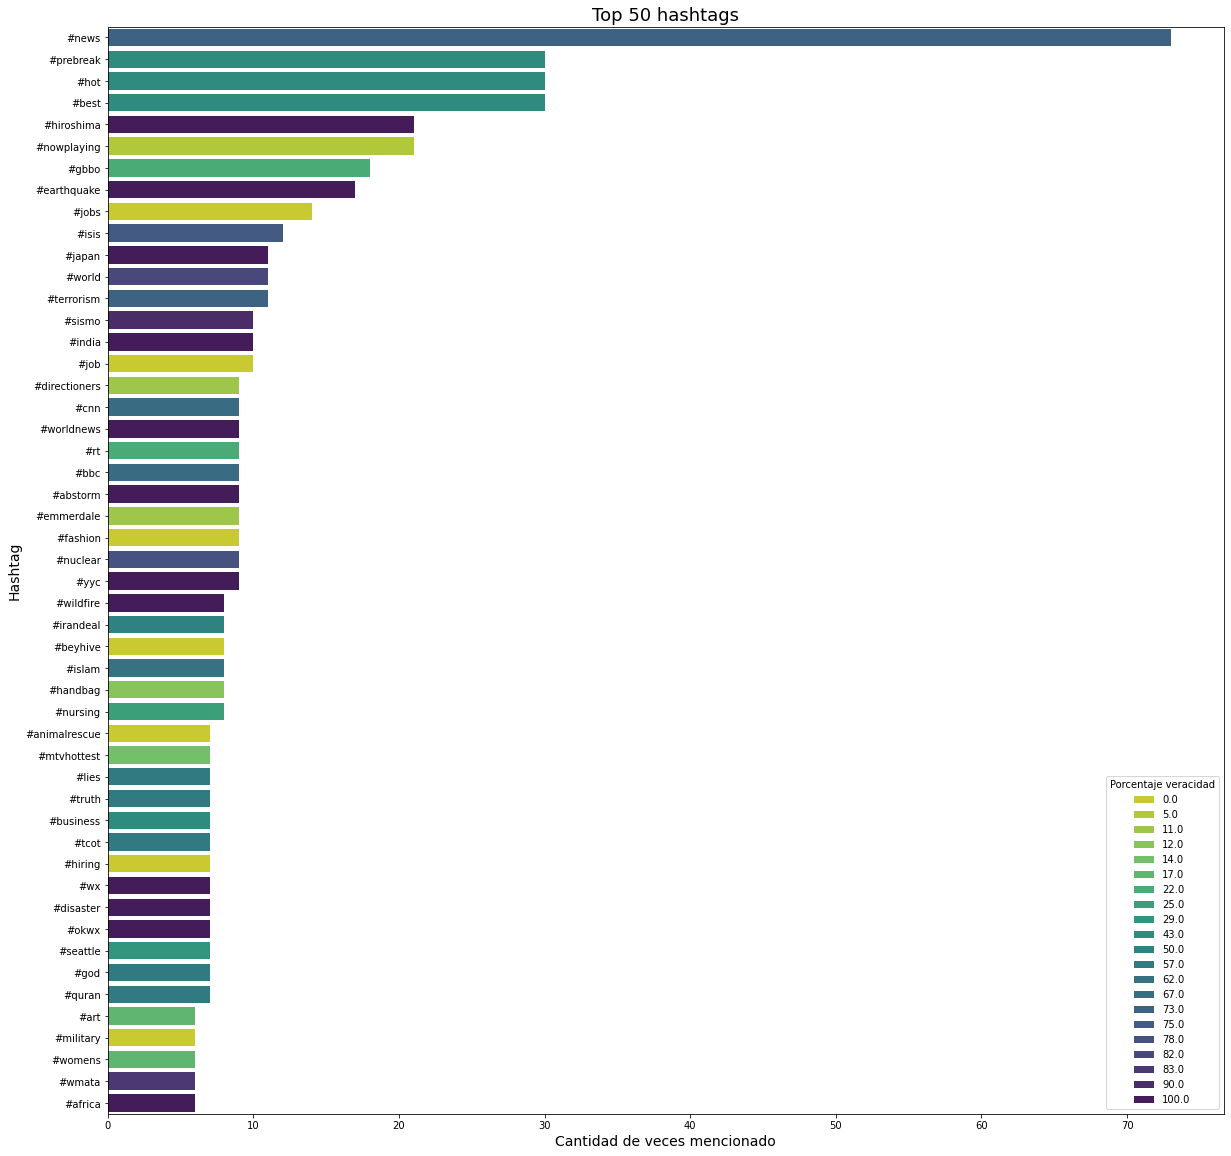

In [17]:
fig = plt.figure(figsize = (20, 20))
plot = sns.barplot(data = hashtags_top, x = ("target","count"), y = 'hashtags', hue = ('target','mean'), dodge = False, palette = "viridis_r")
plot.set_title("Top 50 hashtags", fontsize = 18)
plot.set_xlabel("Cantidad de veces mencionado", fontsize = 14)
plot.set_ylabel("Hashtag", fontsize = 14)
plt.legend(title='Porcentaje veracidad', loc='lower right')
plt.show(plot)

### Hashtags más usados en tweets reales y falsos

In [18]:
tweets_hashtags.head()

,id,keyword,location,text,target,hashtags
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,#earthquake
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,#wildfires
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,#alaska
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,#wildfires
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1,#rockyfire


In [19]:
true_by_hashtags = tweets_hashtags.groupby("target").get_group(1)
top_true_hashtags = true_by_hashtags.groupby('hashtags').agg({'target':'count'})
top_true_hashtags.columns = ["real"]
top_true_hashtags = top_true_hashtags.nlargest(50, columns='real')
top_true_hashtags.head()

,real
hashtags,
#news,53
#hiroshima,21
#earthquake,17
#best,13
#hot,13


[]

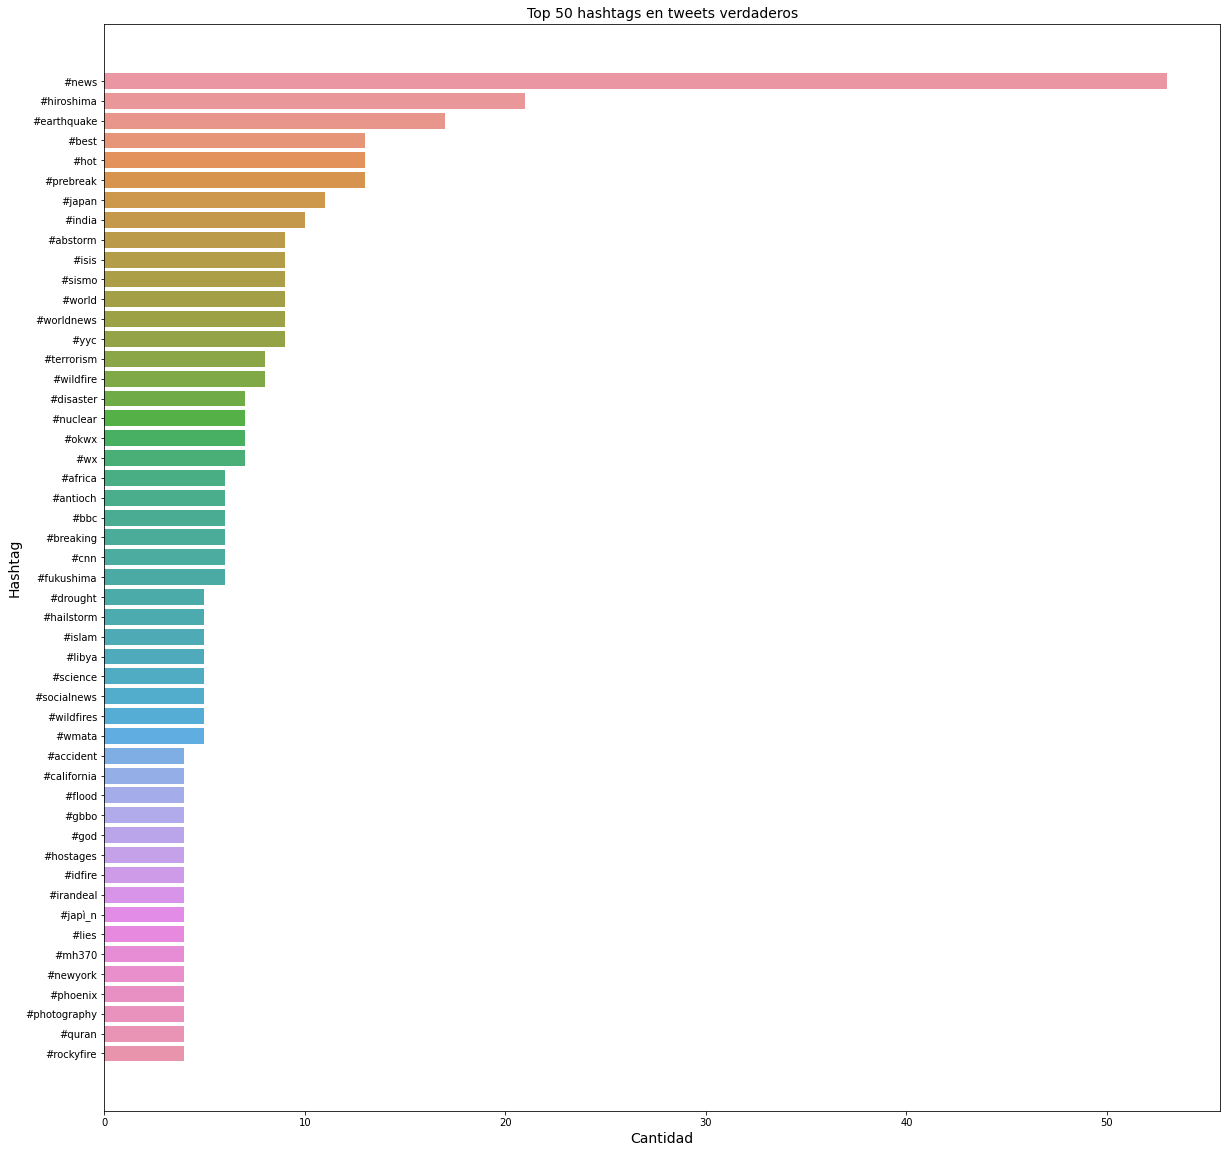

In [20]:
fig = plt.figure(figsize=(20,20))
grafico = sns.barplot(data = top_true_hashtags,x = "real",y = top_true_hashtags.index)
grafico.set_title("Top 50 hashtags en tweets verdaderos",fontsize = 14)
grafico.set_xlabel("Cantidad",fontsize = 14)
grafico.set_ylabel("Hashtag",fontsize = 14)
grafico.plot()

In [21]:
false_by_hashtags = tweets_hashtags.groupby("target").get_group(0)
top_fake_hashtags = false_by_hashtags.groupby('hashtags').agg({'target':'count'})
top_fake_hashtags.columns = ["fake"]
top_fake_hashtags = top_fake_hashtags.nlargest(50, columns="fake")
top_fake_hashtags.head()

,fake
hashtags,
#news,20
#nowplaying,20
#best,17
#hot,17
#prebreak,17


[]

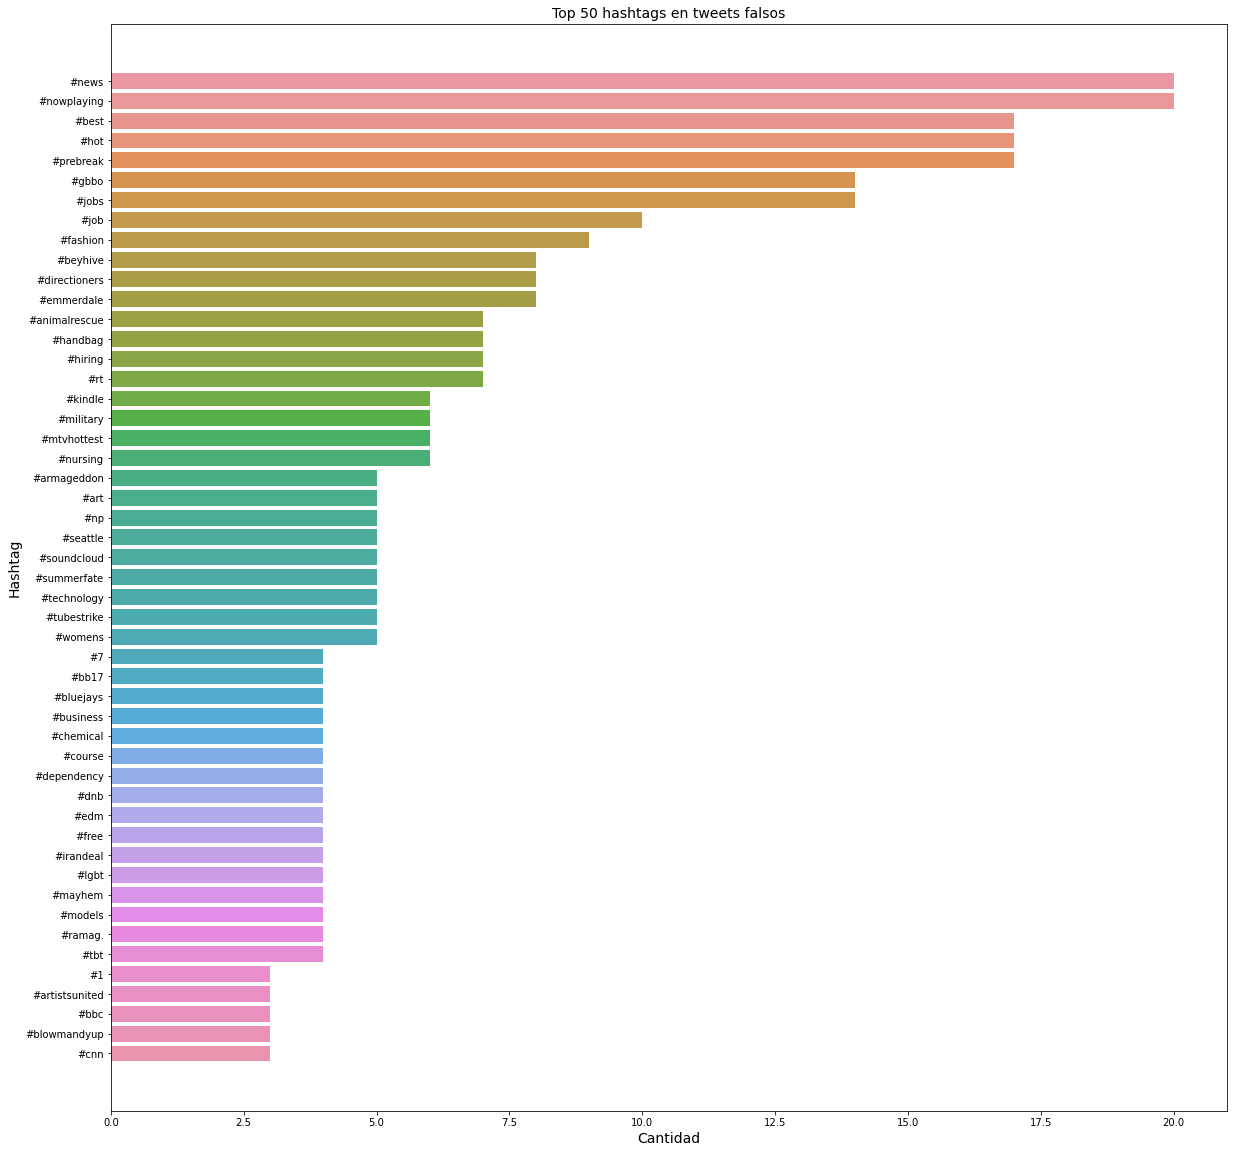

In [22]:
fig = plt.figure(figsize=(20,20))
grafico = sns.barplot(data = top_fake_hashtags,x = "fake",y = top_fake_hashtags.index)
grafico.set_title("Top 50 hashtags en tweets falsos",fontsize = 14)
grafico.set_xlabel("Cantidad",fontsize = 14)
grafico.set_ylabel("Hashtag",fontsize = 14)
grafico.plot()

In [23]:
true_hashtags = ' '.join(true_by_hashtags["hashtags"].str.lower())
fake_hashtags = ' '.join(false_by_hashtags["hashtags"].str.lower())

In [27]:
from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator
import imageio

twitter_coloring = imageio.imread("img/twitter.png",pilmode='RGB')
wc = WordCloud(width = 1920,height = 1080,background_color = "black",mask=twitter_coloring)
image_colors = ImageColorGenerator(twitter_coloring)

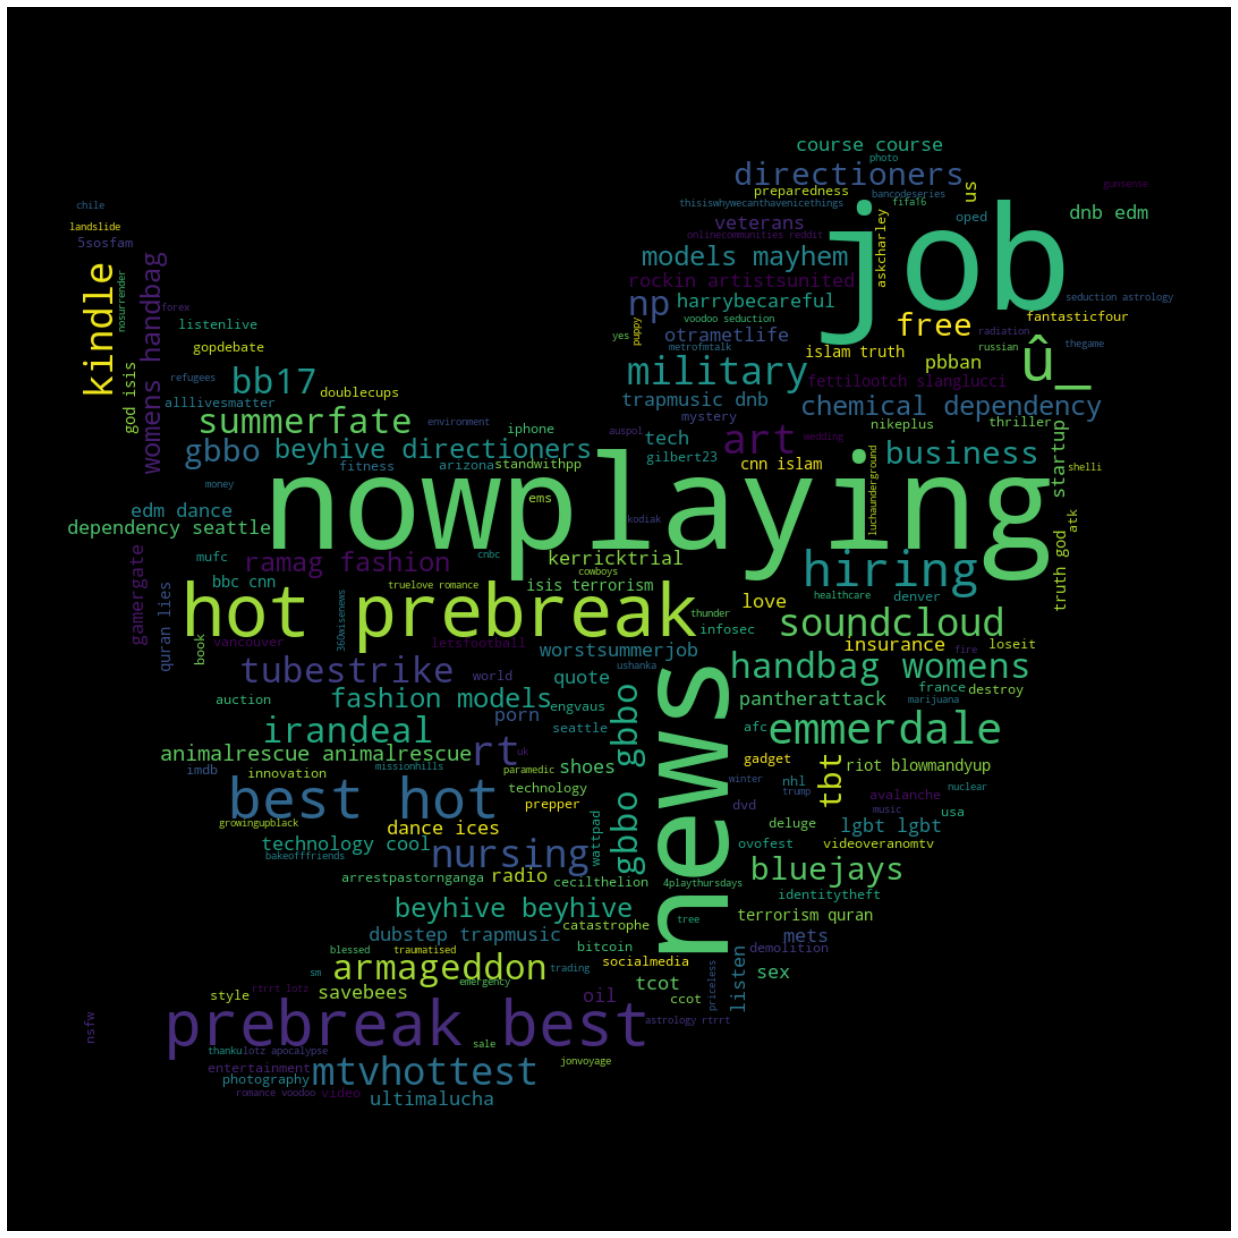

In [28]:
wc.generate(fake_hashtags)
fig, ax = plt.subplots(figsize=(17,17))
ax.imshow(wc, interpolation="bilinear")
ax.set_axis_off()
plt.tight_layout(pad=0)
plt.show()

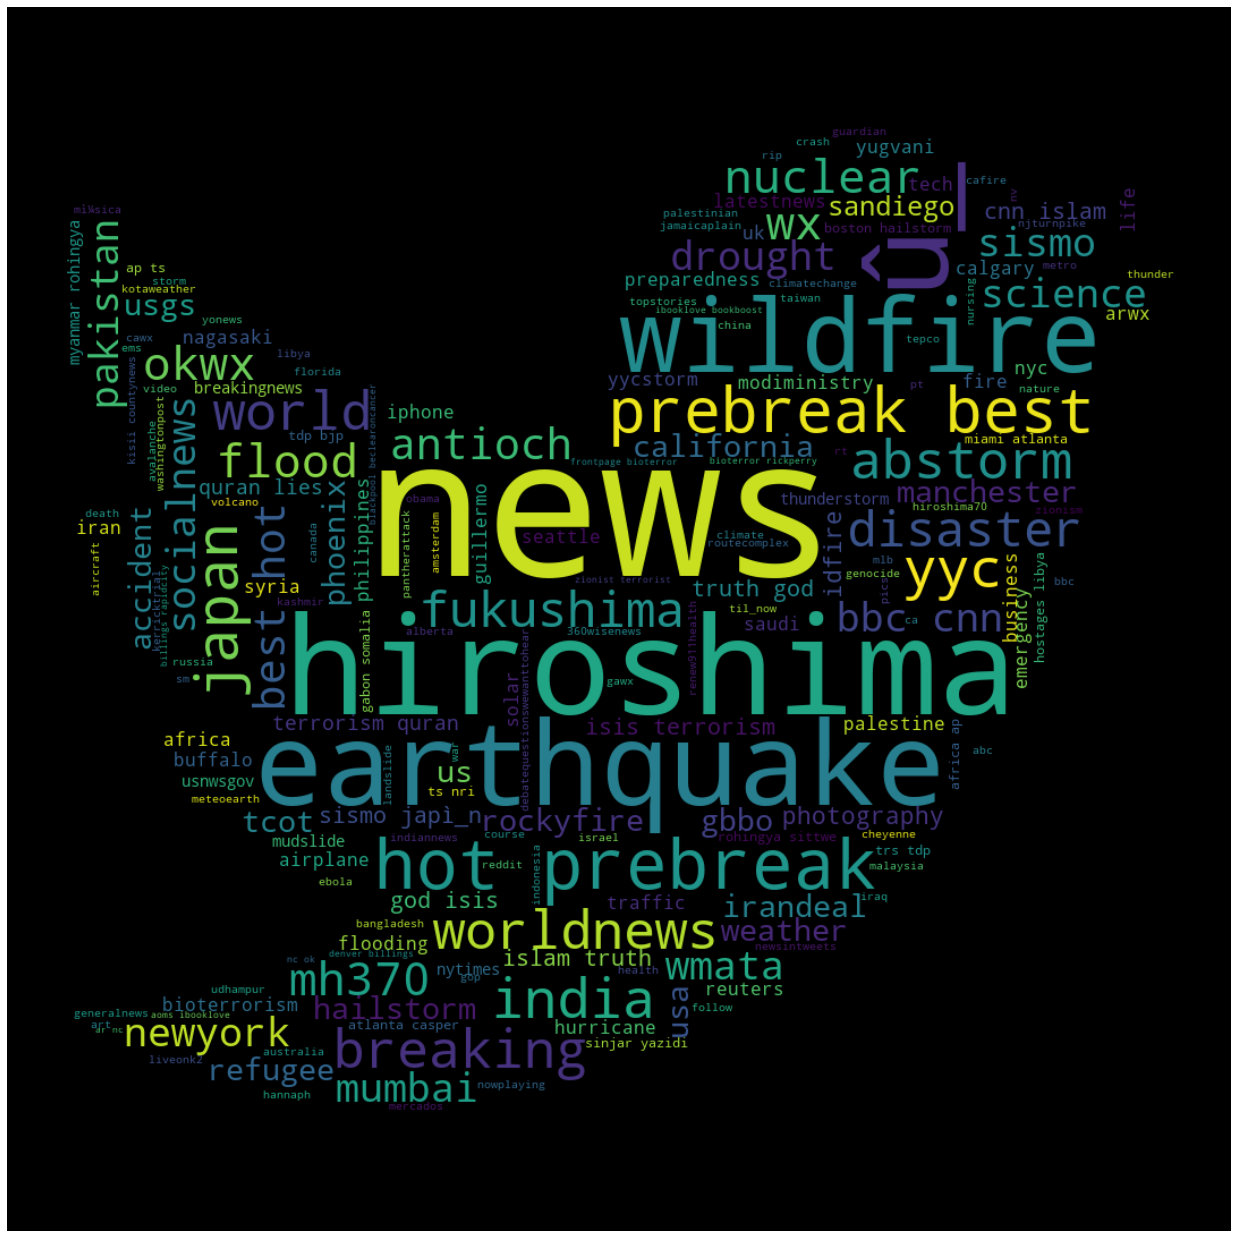

In [29]:
wc.generate(true_hashtags)
fig, ax = plt.subplots(figsize=(17,17))
ax.imshow(wc, interpolation="bilinear")
ax.set_axis_off()
plt.tight_layout(pad=0)
plt.show()

In [ ]:
all_hashtags = pd.concat([top_true_hashtags,top_fake_hashtags],join="outer",axis=1)
all_hashtags.fillna(0,inplace=True)
all_hashtags['total'] = all_hashtags['real'] + all_hashtags['fake']
top_20_hashtags = all_hashtags.nlargest(20, "total")
ax = top_20_hashtags.sort_values(by='total').loc[:, ['real', 'fake']].plot(kind='barh', figsize=(10, 10))

In [ ]:
both_hashtags = pd.concat([top_true_hashtags,top_fake_hashtags],join="outer",axis=1)
both_hashtags.dropna(inplace=True)
ax = both_hashtags.loc[:, ['real', 'fake']].sort_values(by='real').plot(kind='barh', figsize=(10, 10))

### Trending topics de las ciudades con más desastres

In [ ]:
tweets_hashtags.dropna(subset = ['location', 'hashtags'], inplace= True)
tweets_hashtags = tweets_hashtags.loc[(tweets.target == 1), :]
hashtag_by_loc = tweets_hashtags.groupby('location').agg({'location':'count', 'hashtags': 'max'})
hashtag_by_loc = hashtag_by_loc.rename(columns = {'location': 'count'})
hashtag_by_loc = hashtag_by_loc.reset_index()
hashtag_by_loc = hashtag_by_loc.nlargest(25, 'count')
hashtag_by_loc.head()

In [ ]:
fig = plt.figure(figsize = (20, 20))
palette = sns.diverging_palette(220, 20, n=25)
grafico = sns.barplot(data = hashtag_by_loc, x = 'count', y = 'hashtags', hue = 'location', dodge = False, palette = palette)
grafico.set_title("Hashtags mas usados en las top 25 ubicaciones del mundo", fontsize = 14)
grafico.set_xlabel("Cantidad de veces mencionado", fontsize = 14)
grafico.set_ylabel("Hashtag", fontsize = 14)
plt.legend(title='Ubicacion', loc='lower right')
plt.show(grafico)

### Top palabras con más apariciones en tweets

In [ ]:
def by_word_count(dataframe):
    word_list = dataframe["text"].str.split()
    all_stopwords_gensim = STOPWORDS.union(set(string.punctuation))
    filtered = [word.lower() for word in np.concatenate(word_list.values) if not word in all_stopwords_gensim]
    words = pd.DataFrame(filtered,columns = ["word"])
    words["amount"] = 1
    by_count = words.groupby(["word"]).agg({"amount":["count"]})
    level0 = by_count.columns.get_level_values(0)
    level1 = by_count.columns.get_level_values(1)
    by_count.columns = level0 + "_" + level1
    by_count.sort_values(by="amount_count",ascending = False,inplace = True)
    return by_count.head(10)

In [ ]:
true_by_word = tweets["target"] == 1
true_by_word = by_word_count(tweets[true_by_word])

false_by_word = tweets["target"] == 0
false_by_word = by_word_count(tweets[false_by_word])

In [ ]:
fig = plt.figure(figsize=(20,20))
grafico = sns.barplot(data = true_by_word,x = "amount_count",y=true_by_word.index)
grafico.set_title("Top 10 palabras usadas en tweets verdaderos",fontsize = 14)
grafico.set_xlabel("Cantidad de veces",fontsize = 14)
grafico.set_ylabel("Palabra",fontsize = 14)
grafico.plot()

In [ ]:
fig = plt.figure(figsize=(20,20))
grafico = sns.barplot(data = false_by_word,x = "amount_count",y=false_by_word.index)
grafico.set_title("Top 10 palabras usadas en tweets falsos",fontsize = 14)
grafico.set_xlabel("Cantidad de veces",fontsize = 14)
grafico.set_ylabel("Palabra",fontsize = 14)
grafico.plot()

### Análisis por longitud de tweet

In [ ]:
tweets_length = tweets[['text','target']]
tweets_length.count()

In [ ]:
tweets_length['text'].hasnans

In [ ]:
tweets_length['length'] = tweets_length['text'].str.len()
tweets_length.head()

In [ ]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,8))
tweet_len = tweets_length[tweets_length['target'] == 1]['length']
ax1.hist(tweet_len,color='green')
ax1.set_title('Tweets reales')
tweet_len = tweets_length[tweets_length['target'] == 0]['length']
ax2.hist(tweet_len,color='red')
ax2.set_title('Tweets falsos')
fig.suptitle('Comportamiento de la longitud del tweet')
plt.show()

In [ ]:
g = sns.boxplot(x = 'target', y = 'length', data = tweets_length, width = 0.4,\
                palette = [(0.86, 0.3712, 0.33999999999999997),(0.30196078431372547, 0.6862745098039216, 0.2901960784313726)])
g.set_title("Largo de los tweets según target", fontsize = 25)
g.set_xlabel("Veracidad (0 = Falso, 1 = Verdadero)", fontsize = 15)
g.set_ylabel("Largo de los tweets (en caracteres)", fontsize = 15)
sns.set(rc = {'figure.figsize' : (15,10)})
plt.show()

In [ ]:
tweets_length['avg_word_length'] = tweets_length['text'].str.split().apply(lambda x: [len(y) for y in x]).transform(lambda x: np.mean(x))
tweets_length.head()

In [ ]:
fig = px.histogram(tweets_length, x="avg_word_length", color="target", marginal="box", width = 1200, height = 550,
                             nbins = 300, title = 'Distribución de largo promedio de palabras por tweet individual')
fig.update_layout(
    xaxis_title="Largo promedio de la palabra",
    yaxis_title="Cantidad",
    font=dict(
        family="Courier New, monospace",
        size=15,
        color="#7f7f7f"
    )
)
fig.update_layout(legend_title_text="Veracidad")


fig.show()

In [ ]:
tweets_length['amount_of_words'] = tweets_length['text'].str.split().transform(lambda x: len(x))
tweets_length.head()

In [ ]:
g = sns.kdeplot(tweets_length[tweets_length['target'] == 1]['amount_of_words'], color="blue", label='Cant de palabras por tweet Target = 1', shade=True)
g = sns.kdeplot(tweets_length[tweets_length['target'] == 0]['amount_of_words'], color="red", label='Cant de palabras por tweet Target = 0', shade=True)

#plt.yticks(g.get_yticks(),[int(round(item,0)) for item in (g.get_yticks() * 100)])

g.set_title('Cantidad de palabras por tweet según target', fontsize = 20)
g.set_xlabel('Longitud en palabras del tweet', fontsize = 15)
plt.show()

In [ ]:
#Cantidad de palabras únicas (aka sin repetir) en el tweet

unique_words_by_tweet = tweets_length['text'].transform(lambda x: x.split()).transform(lambda x: pd.Series(x).unique()).transform(lambda x: len(x))
tweets_length['amount_of_unique_words'] = unique_words_by_tweet
tweets_length

In [ ]:
#Hipotesis: los de target 1 no repiten tantas palabras (?).
#Resultado: son casi lo mismo pero weno podemos dejarlo.
g = sns.kdeplot(tweets_length[tweets_length['target'] == 1]['amount_of_unique_words'], color="blue", label='Cant de palabras únicas por tweet Target = 1', shade=True)
g = sns.kdeplot(tweets_length[tweets_length['target'] == 0]['amount_of_unique_words'], color="red", label='Cant de palabras únicas por tweet Target = 0', shade=True)

#plt.yticks(g.get_yticks(),[int(round(item,0)) for item in (g.get_yticks() * 100)])

g.set_title('Cantidad de palabras únicas por tweet según target', fontsize = 20)
g.set_xlabel('Longitud en palabras únicas del tweet', fontsize = 15)
plt.show()

In [ ]:
tweets_length['avg_length'] = tweets_length.groupby('target')['length'].transform('mean')
tweets_length.head()

In [ ]:
tweets_length['is_above_avg_length'] = tweets_length['length'] > tweets_length['avg_length']
tweets_length.head()

In [ ]:
groupedby_is_above_avg_length = tweets_length.groupby('is_above_avg_length').agg({'target':['mean','count']})
groupedby_is_above_avg_length

In [ ]:
groupedby_is_above_avg_length[('target','mean')].plot(kind = 'bar', figsize = (15,10), rot = 0, colormap = 'Accent')
plt.title('Target promedio segun si sobrepasan el largo promedio', fontsize = 20)
plt.xlabel('Está por arriba del largo promedio', fontsize = 15)
plt.ylabel('Target promedio', fontsize = 15)
plt.ylim(0,1)
plt.show()

In [ ]:
#Añadimos columna de si contiene link o no

tweets_length['contains_link'] = tweets_length['text'].str.contains('http://' or 'https://')

In [ ]:
tweets_to_corr = tweets_length[['length','target','is_above_avg_length','avg_word_length','amount_of_words','amount_of_unique_words','contains_link']]

tweets_to_corr['avg_target_by_length'] = tweets_length.groupby('length')['target'].transform('mean')
tweets_to_corr.head(20)
tweets_to_corr.corr(method = 'spearman')

In [ ]:
sns.heatmap(tweets_to_corr.corr(method = 'spearman'), annot = True)
plt.title('Heatmap de correlación entre distintas columnas', fontsize = 20)

plt.show()

### Relacion: links en tweet vs. veracidad

In [ ]:
#Si contienen links ver su target

sns.set(style="whitegrid")
g = sns.countplot(x = 'target', hue = "contains_link", data = tweets_length, palette = [sns.color_palette()[3], sns.color_palette()[2]])

g.set_title('Cantidad de tweets que poseen o no links según target', fontsize = 20)
g.set_xlabel('Veracidad (verdadero o falso)', fontsize = 20)
g.set_ylabel('Cantidad de tweets', fontsize = 20)
plt.ylim(0,3000)
sns.set(rc = {'figure.figsize' : (15,10)})

g.legend(['No','Si'], loc = 'upper right', title = 'Contiene link');

plt.show()

In [ ]:
#Pispeo los valores
tweets_length[tweets_length['contains_link']].groupby('target').agg({'length':['count', 'mean']})

In [ ]:
g = sns.boxplot(x = 'target', y = 'length', data = tweets_length[tweets_length['contains_link']], palette = [(0.596078431372549, 0.3058823529411765, 0.6392156862745098),
 (1.0, 0.4980392156862745, 0.0)], width = 0.4)
g.set_title("Largo de los tweets que poseen links según target", fontsize = 25)
g.set_xlabel("Veracidad (0 = Falso, 1 = Verdadero)", fontsize = 15)
g.set_ylabel("Largo de los tweets (en caracteres)", fontsize = 15)
sns.set(rc = {'figure.figsize' : (15,10)})

Según twitter developer:
When a HTTPS-based URL is passed while link wrapping is enabled, a HTTPS-based t.co link will be produced. HTTPS-based t.co links are one character longer than standard t.co links to account for the protocol change.

Esto es porque los HTTPS son más seguros.

In [ ]:
contains_https = tweets_length[tweets_length['text'].str.contains('https://')].groupby('target')['text'].count()
contains_http = tweets_length[tweets_length['text'].str.contains('http://')].groupby('target')['text'].count()
contains_link = pd.DataFrame({'contains_safer_link': contains_https, 'contains_non_safer_link': contains_http})
contains_link

In [ ]:
#Hipotesis: uno esperaria que la utilizacion de links SEGUROS sea para los desastres reales ya que lo proveen agencias de noticias.
#Dato: Hay muy pocos links seguros en el dataset

#Hipotesis: uno esperaria que la utilizacion de links NO SEGUROS sea para los no desastres ya que lo provee cualquiera.
#Dato: Hay muchos links inseguros en el dataset

graph = contains_link.plot(color=["SkyBlue","IndianRed"], kind = 'bar', figsize = (15,10), rot = 0)

graph.legend(['Contiene link más seguro','Contiene link menos seguro'], loc = 'upper right')
plt.title('Cantidad de tweets que poseen links seguros o no seguros según target', fontsize = 20)
plt.xlabel('Veracidad (0 = Falso, 1 = Verdadero)', fontsize = 20)
plt.ylabel('Cantidad de tweets con links', fontsize = 20)
plt.ylim(0,2250)
plt.show()

### Análisis de sentimiento de tweet

Primera hipotesis: Al ser cosas noticiosas deberian ser mas neutras.

Pero, teniendo en cuenta que procesa el sentimiento.
Deberian ser neutros tendiendo a negativos ya que al ser desastres naturales son literalmente eso, desastres, y se espera el uso de ciertas palabras que no implican algo muy positivo.

Además, al informar sobre desastres naturales las palabras que describen este tipo de eventos apuntan en general a cosas más negativas.

In [ ]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

In [ ]:
sia = SentimentIntensityAnalyzer()
def return_sia_compound_values(text):
    return sia.polarity_scores(text)['compound']

tweets_feeling_1 = tweets_length.groupby('target')['text'].get_group(1).apply(lambda x: return_sia_compound_values(x))
tweets_feeling_0 = tweets_length.groupby('target')['text'].get_group(0).apply(lambda x: return_sia_compound_values(x))

In [ ]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,8))

sns.distplot(tweets_feeling_0, bins = 40, color = 'SkyBlue', ax = ax1)
ax1.set_title('Sentimiento - Target = 0', fontsize = 15)
ax1.set_xlabel('Sentimiento', fontsize = 15)

sns.distplot(tweets_feeling_1, bins = 40, color = 'SkyBlue', ax = ax2)
ax2.set_title('Sentimiento - Target = 1', fontsize = 15)
ax2.set_xlabel('Sentimiento', fontsize = 15)

ax1.set_ylim(0,6)
ax2.set_ylim(0,6)
fig.suptitle('Sentimiento del tweet. De -1 a 1, más negativo a más positivo.', fontsize = 20)
plt.show()

In [ ]:
def return_sia_values(text):
    return [sia.polarity_scores(text)['pos'], sia.polarity_scores(text)['neg'], sia.polarity_scores(text)['neu']]

sia_values = tweets_length['text'].transform(lambda x: return_sia_values(x)).to_frame()

sia_values['pos'] = sia_values['text'].apply(lambda x: pd.Series(x[0]))
sia_values['neg'] = sia_values['text'].apply(lambda x: pd.Series(x[1]))
sia_values['neu'] = sia_values['text'].apply(lambda x: pd.Series(x[2]))

sia_values['target'] = tweets_length['target']
sia_values.head()

In [ ]:
ax = sia_values.groupby('target').mean()[['pos', 'neg', 'neu']].plot.area(cmap='Pastel2', figsize=(10, 8))
ax.set_xlabel('Veracidad. 0: Falso, 1: Verdadero.')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], ['Sentimiento Neutro', 'Sentimiento Negativo', 'Sentimiento Positivo'], loc='upper left');

### Análisis de uso de puntuación.

In [ ]:
tweets_punctuation = tweets[['text','target']]

In [ ]:
def contains_punctuation(text):
    punctuation = set(string.punctuation)
    for character in text:
        if character in punctuation:
            return True
    return False

def amount_of_punctuation(text):
    punctuation = set(string.punctuation)
    amount = 0
    for character in text:
        if character in punctuation: amount += 1
    return amount

In [ ]:
tweets_punctuation['contains_punctuation'] = tweets_punctuation['text'].apply(lambda x: contains_punctuation(x))
tweets_punctuation['amount_of_punctuation'] = tweets_punctuation['text'].apply(lambda x: amount_of_punctuation(x))

#Me quedo con los tweets que su cantidad de puntuaciones sea menor a 10 veces la desviacion estandar, ya que el promedio no seria util por el previo analisis
#de que hay unos pocos tweets con una cantidad de puntuaciones que no aportan al analisis (solo 4 mayores a 50 en cantidad)

tweets_punctuation = tweets_punctuation[(tweets_punctuation['amount_of_punctuation']) < (tweets_punctuation['amount_of_punctuation'].std() * 10)]
tweets_punctuation.groupby('target')['amount_of_punctuation'].describe()

In [ ]:
ax = sns.violinplot(x  ="target", y = "amount_of_punctuation", data = tweets_punctuation, palette = [(0.8, 0.7254901960784313, 0.4549019607843137),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451)])

ax.set_title('Cantidad de caracteres de puntuación utilizados en un tweet por target', fontsize = 20)
ax.set_xlabel('Veracidad. Verdadero: target = 1; Falso: target = 0 ', fontsize = 15)
ax.set_ylabel('Cantidad de caracteres de puntuación utilizados en el tweet', fontsize = 15)

plt.show()

### Personas más mencionadas

In [ ]:
tweets_with_mentions = tweets.loc[tweets['text'].str.contains('@'), ['text', 'target']]
mentions = tweets_with_mentions['text'].str.findall(r'@.\S*?(?=\s|[:]|$)').to_frame()
#La regex encuentra todas las palabras que empiecen con '@' y al mismo tiempo elimina los '@:' y '@ '
#El arroba se usa como expresion para indicar la hora tambien

In [ ]:
mentions.head()

In [ ]:
mentions['target'] = tweets_with_mentions['target']

In [ ]:
mentions.head()

In [ ]:
mentions_to_group = mentions.explode('text')

In [ ]:
mentions_to_group.head()

In [ ]:
mentions_grouped = mentions_to_group.groupby(['text']).agg({'text': 'count', 'target':'sum'}).nlargest(20, 'text')
mentions_grouped['fake'] = mentions_grouped['text'] - mentions_grouped['target']
mentions_grouped.columns = ['total', 'real', 'fake']

In [ ]:
mentions_grouped.head()

In [ ]:
mentions_grouped.loc[:, 'total'].plot(kind='barh', title='Top mentioned accounts', color=(0.2, 0.2, 0.6, 0.8), figsize=(16, 8))
ax = plt.gca()
ax.set_ylabel('Mention')
ax.set_xlabel('Account')

In [ ]:
ax = mentions_grouped.sort_values(by=['fake']).loc[:, ['real', 'fake']].plot(kind='barh', figsize=(10, 10))
ax.set_ylabel('Mentions')
ax.set_xlabel('Account')

### Top ciudades con mayor cantidad de tweets reales y falsos

In [ ]:
#No importan las locaciones NAN
partial = tweets.dropna()

In [ ]:
partial.info()

In [ ]:
locations = partial[partial['location'].str.match(r'^([a-zA-Z,\s])*$') > 0]
locations.head()

In [ ]:
locations.info()

In [ ]:
locations['location'] = locations['location'].str.lower()

In [ ]:
locations.head()

In [ ]:
#20 lugares con mas tweets
top_20_locations = locations['location'].value_counts().nlargest(20).to_frame()
top_20_locations

In [ ]:
top_20_locations.plot(kind='barh',  rot=0, title='Top locations with most tweets', color=(0.2, 0.2, 0.6, 0.8), figsize=(16, 8))
ax = plt.gca()
ax.set_ylabel('Tweets')
ax.set_xlabel('Location')

In [ ]:
locations.head()

In [ ]:
by_location = locations.groupby(['location']).agg({'target':['count', 'sum']})
level_0 = by_location.columns.get_level_values(0)
level_1 = by_location.columns.get_level_values(1)
by_location.columns = level_0 + '_' + level_1
by_location.reset_index(inplace=True)
by_location.head()

In [ ]:
by_location.info()

In [ ]:
import os.path
if(not os.path.isfile('locations.csv')):
    get_geodata()

def get_geodata():
    from geopy.geocoders import Nominatim
    from tqdm import tqdm
    from geopy.extra.rate_limiter import RateLimiter
    geolocator = Nominatim(user_agent="mile.marchese@gmail.com")
    tqdm.pandas()
    geocode = RateLimiter(geolocator.geocode, min_delay_seconds=2, max_retries=0)
    by_location['geodata'] = by_location['location'].progress_apply(geocode)
    by_location['address'] = by_location['geodata'].apply(lambda loc: loc.address if loc else None)
    by_location['point'] = by_location['geodata'].apply(lambda loc: tuple(loc.point) if loc else None)
    by_location.to_csv('locations.csv', index=False)

In [ ]:
address = pd.read_csv('locations.csv', usecols=['location', 'target_count', 'target_sum', 'address']) 
address.head()

In [ ]:
#Hay 374 que geopy no encontró
address.info()

In [ ]:
#Se puede correr de nuevo geopy 
not_found_addr = address[address['address'].isnull()]
not_found_addr.head()

In [ ]:
address['address'].describe()

In [ ]:
not_found_addr['target_count'].value_counts(normalize=True)

In [ ]:
address['address'].describe()

In [ ]:
by_address = address.groupby(['address']).agg({'target_count':'sum', 'target_sum': 'sum'\
                                               , 'location': lambda x: "%s" % '-'.join(set(x))}).reset_index()
by_address.head()

In [ ]:
by_address.columns = ['address', 'total', 'real', 'location_list']

In [ ]:
by_address['fake'] = by_address['total'] - by_address['real']
by_address.head()

In [ ]:
by_address.describe()

In [ ]:
#10 ciudades que mas reales tienen
most_real = by_address.nlargest(10, 'real').loc[:, ['address', 'real']].set_index('address')
most_real

In [ ]:
most_real.plot(kind='barh',  rot=0, title='Top locations with real tweets', color=(0.2, 0.2, 0.6, 0.8), figsize=(14, 7))
ax = plt.gca()
ax.set_xlabel('Tweets')
ax.set_ylabel('Location')

In [ ]:
#10 ciudades que mas falsos tienen
most_fake = by_address.nlargest(10, 'fake').loc[:,['address', 'fake']].set_index('address')
most_fake

In [ ]:
most_fake.plot(kind='barh',  rot=0, title='Top locations with fake tweets', color=(0.2, 0.2, 0.6, 0.8), figsize=(14, 7))
ax = plt.gca()
ax.set_xlabel('Tweets')
ax.set_ylabel('Location')

### Locaciones no encontradas

In [ ]:
not_found_addr.head()

In [ ]:
not_found_addr = not_found_addr.drop(columns=['address'])
not_found_addr.columns = ['location', 'total', 'real']

In [ ]:
grouped_by_fake_loc = not_found_addr.groupby(['location']).agg({'total':'sum', 'real':'sum'}).reset_index()

In [ ]:
grouped_by_fake_loc['fake'] = grouped_by_fake_loc['total'] - grouped_by_fake_loc['real']
grouped_by_fake_loc.head()

In [ ]:
most_used_fake_loc = grouped_by_fake_loc.nlargest(15, 'total')
most_used_fake_loc

In [ ]:
most_used_fake_loc_real = grouped_by_fake_loc.nlargest(15, 'real')
most_used_fake_loc_real

In [ ]:
most_used_fake_loc_fake = grouped_by_fake_loc.nlargest(15, 'fake')
most_used_fake_loc_fake

### Top paises participantes

In [ ]:
by_address['country'] = by_address['address'].str.split(pat = ",")
by_address.head()

In [ ]:
by_address.loc[:, 'country'] = by_address.country.map(lambda x: x[-1])

In [ ]:
by_address.head()

In [ ]:
by_address.loc[:, 'country'] = by_address.country.str.strip()
by_country = by_address.groupby(['country']).agg({'total': 'sum', 'real': 'sum', 'fake': 'sum'}).reset_index().sort_values('total', ascending=False)
by_country.head()

In [ ]:
by_country.info()

In [ ]:
countries = pd.Series(by_country.country).to_list()

In [ ]:
import re
alpha_space = re.compile('^[a-zA-Z_ ]*$')

to_change = {}
for element in countries:
    coincidences = [s for s in countries if element in s]
    if len(coincidences) > 1:
        name = max(coincidences, key=len)
        if not alpha_space.match(name):
            name = min(coincidences, key=len)
        to_change.update({coincidence:name for coincidence in coincidences if coincidence != name})
    
print(to_change)

In [ ]:
to_change.pop('Africa', None)

In [ ]:
by_country.country = by_country.country.replace(to_change) 

In [ ]:
by_country.head()

In [ ]:
by_country = by_country.groupby(['country']).agg({'total': 'sum', 'real': 'sum', 'fake': 'sum'}).reset_index().sort_values('total', ascending=False)
by_country.nlargest(10, 'total')

In [ ]:
import geopandas
#world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
#world.head()

In [ ]:
#try:
#    from googletrans import Translator
#    translator = Translator()
#    by_country['translated_country'] = by_country['country'].apply(translator.translate, dest='en').apply(getattr, args=('text',))
#    by_country.head()
#except Exception as e:
#    print(e)

In [ ]:
#by_country

In [ ]:
#world = world.merge(by_country, left_on='name', right_on='translated_country', how='left')
#world.head()

In [ ]:
#world = world[(world.name!="Antarctica")]
#fig= plt.figure(figsize=(15,10))
#ax = fig.add_axes([0, 0, 1, 1])
#ax.axis('off')
#world.plot(column="total", legend=True,\
#           legend_kwds={'label': "Cantidad de tweets por pais", 'orientation': "horizontal"},\
#           missing_kwds={"color": "lightgrey", "label": "Missing values"}, cmap='tab20b', ax=ax)

In [ ]:
#top_by_country = by_country.nlargest(10, 'total')

In [ ]:
#import squarify
#import matplotlib
#
#norm = matplotlib.colors.Normalize(vmin=min(top_by_country.total), vmax=max(top_by_country.total))
#colors = [matplotlib.cm.Blues(norm(value)) for value in top_by_country.total]
#fig = plt.gcf()
#ax = fig.add_subplot()
#fig.set_size_inches(16, 4.5)
#squarify.plot(label=top_by_country.country,sizes=top_by_country.total, alpha=.6)
#plt.title('Top paises con más tweets', fontsize=23, fontweight='bold')
#plt.axis('off')
#plt.show()

In [ ]:
#ax = by_country.set_index('country').nlargest(10, 'total').sort_values(by=['real']).loc[:, ['real', 'fake']].plot(kind='barh', figsize=(10, 10))
#ax.set_ylabel('Mentions')
#ax.set_xlabel('Account')

### Relacion real-falso con location, keyword vacías

In [ ]:
tweets.head()

In [ ]:
no_location = tweets[tweets['location'].isnull()]
no_keyword = tweets[tweets['keyword'].isnull()]

In [ ]:
no_location.head()

In [ ]:
no_keyword.head()

In [ ]:
no_location.info()

In [ ]:
no_keyword.info()

In [ ]:
no_location['len'] = no_location['text'].str.len()

In [ ]:
no_location.head()

In [ ]:
no_location['target'].value_counts()

In [ ]:
no_keyword['target'].value_counts()

In [ ]:
ax = sns.boxplot(x="target", y="len", data=no_location, width = 0.5)
ax.set_title("Longitud del tweet sin ubicación según sea verdadero o falso", fontsize=18)
ax.set_xlabel("Veracidad (0 = Falso, 1 = Verdadero)", fontsize=14)
ax.set_ylabel("Largo del tweet", fontsize=14)

### Análisis sobre relación condados costeros de Estados Unidos y el ratio de desastres reales.

In [ ]:
#https://coast.noaa.gov/digitalcoast/training/enow-counties-list.html
#Csv obtenido a partir de esa página que contiene los condados de USA que son costeros

In [ ]:
by_address.head()

In [ ]:
coastal_counties = pd.read_csv('coastal_counties_usa.csv', usecols = ['County','State','FIPS'])
coastal_counties.head()

In [ ]:
coastal_counties['Location'] = coastal_counties[['County','State']].agg(','.join, axis = 1) + ',' + coastal_counties['FIPS'].astype('str')
#coastal_counties['Location'] = coastal_counties['State'] + ',' + coastal_counties['FIPS'].astype('str')
coastal_counties.head()

In [ ]:
coastal_counties_list = coastal_counties['Location'].to_list()
coastal_counties_dict = {}
for location in coastal_counties_list:
    county, state, FIPS = location.split(',')
    coastal_counties_dict[county] = coastal_counties_dict.get(county, (state,FIPS))

#coastal_counties_dict = pd.Series(coastal_counties['Location'].to_list(),index=coastal_counties['County']).to_dict()
#coastal_counties_dict

In [ ]:
def is_coastal(lista):
    for word in lista:
        if word in coastal_counties_dict: return True
    return False

def return_coastal_county(lista):
    for word in lista:
        if word in coastal_counties_dict: 
            return word + ',' + coastal_counties_dict[word][0]
            #return word + ',' + coastal_counties_dict[word].split(',')[0]

def return_coastal_county_FIPS(lista):
    for word in lista:
        if word in coastal_counties_dict: 
            return coastal_counties_dict[word][1]
            #return coastal_counties_dict[word].split(',')[1]

us_address = by_address[by_address['address'].str.contains('United States')]
us_address['address'] = us_address['address'].apply(lambda x: x.replace(',','').split())
us_address['is_coastal'] = us_address['address'].apply(lambda x: is_coastal(x))
us_address['coastal_county_name'] = us_address[us_address['is_coastal']]['address'].apply(lambda x: return_coastal_county(x))
us_address['coastal_county_FIPS'] = us_address[us_address['is_coastal']]['address'].apply(lambda x: return_coastal_county_FIPS(x))
us_address[us_address['is_coastal']].head()

In [ ]:
us_realdisasters_FIPS = us_address[us_address['is_coastal']].groupby('coastal_county_FIPS')['real'].sum().to_frame()
us_realdisasters_FIPS = us_realdisasters_FIPS[us_realdisasters_FIPS['real'] > 0]
us_realdisasters_FIPS.head()

In [ ]:
import plotly.figure_factory as ff

fips = us_realdisasters_FIPS.index.tolist()
values = us_realdisasters_FIPS['real'].tolist()

colorscale = ['rgb(0.2235294117647059, 0.23137254901960785, 0.4745098039215686)',
 'rgb(0.3215686274509804, 0.32941176470588235, 0.6392156862745098)',
 'rgb(0.4196078431372549, 0.43137254901960786, 0.8117647058823529)',
 'rgb(0.611764705882353, 0.6196078431372549, 0.8705882352941177)',
 'rgb(0.38823529411764707, 0.4745098039215686, 0.2235294117647059)',
 'rgb(0.5490196078431373, 0.6352941176470588, 0.3215686274509804)',
 'rgb(0.7098039215686275, 0.8117647058823529, 0.4196078431372549)',
 'rgb(0.807843137254902, 0.8588235294117647, 0.611764705882353)',
 'rgb(0.5490196078431373, 0.42745098039215684, 0.19215686274509805)',
 'rgb(0.7411764705882353, 0.6196078431372549, 0.2235294117647059)',
 'rgb(0.9058823529411765, 0.7294117647058823, 0.3215686274509804)',
 'rgb(0.9058823529411765, 0.796078431372549, 0.5803921568627451)',
 'rgb(0.5176470588235295, 0.23529411764705882, 0.2235294117647059)',
 'rgb(0.6784313725490196, 0.28627450980392155, 0.2901960784313726)',
 'rgb(0.8392156862745098, 0.3803921568627451, 0.4196078431372549)']
 
fig = ff.create_choropleth(fips=fips, values=values,colorscale = colorscale, title_text = 'Distribución de tweets reales según condado costero de USA',legend_title = 'Cantidad de tweets reales', state_outline={'color': 'rgb(99,99,99)', 'width': 0.3}, asp = 2.9)
fig.layout.template = None
fig.layout.update({'height': 720})
fig.layout.update({'width': 1280})
fig.show()

En base a lo visto arriba en el mapa, se analiza qué tipo de desastres ocurrieron en dichas ubicaciones.

Hipotesis: Como se vio en las coastal counties uno imaginaria que las keywords de dichos tweets estarian relacionados a desastres comunes en proporcion normal y naturales en proporcion mayor, entre los cuales podria estar inundaciones, huracanes, tornados, tormentas tropicales (florida), entre otros desastres naturales que suelen ocurrir en zonas costeras.

In [ ]:
text_merge = tweets.loc[:, ['text', 'target', 'keyword', 'location']]
text_merge['location'] = text_merge['location'].str.lower()
locations_data = address.loc[:, ['location', 'address']]
text_merge = text_merge.merge(locations_data, left_on='location', right_on='location', how='left')
text_merge = text_merge.loc[ (text_merge['address'].isnull() == False),:]
text_merge.head()

In [ ]:
us_address_keyword = text_merge[text_merge['address'].str.contains('United States')]
us_address_keyword['address'] = us_address_keyword['address'].apply(lambda x: x.replace(',','').split())
us_address_keyword['is_coastal'] = us_address_keyword['address'].apply(lambda x: is_coastal(x))
grouped_by_keyword = us_address_keyword[us_address_keyword['is_coastal']].groupby('target')['keyword']
grouped_by_keyword = grouped_by_keyword.value_counts().to_frame()
grouped_by_keyword.columns = ['count']
grouped_by_keyword = grouped_by_keyword.reset_index().set_index('keyword')
grouped_by_keyword.index = grouped_by_keyword.index.str.replace('%20',' ')
grouped_by_keyword[grouped_by_keyword['target'] == 1]['count'].nlargest(5)

In [ ]:
sns.set(style="whitegrid")
data = grouped_by_keyword[grouped_by_keyword['target'] == 1]['count'].nlargest(20).to_frame()

ax = sns.barplot(x = "count", y = data.index, data = data, orient = 'h', palette = 'tab20c')
ax.set_title('Top 20 tipos de desastres reales en zona costera', fontsize = 20)
ax.set_xlabel('Cantidad de desastres ', fontsize = 15)
ax.set_ylabel('Tipo de desastre', fontsize = 15)
plt.show()

In [ ]:
all_stopwords_gensim = STOPWORDS.union(set(string.punctuation))
tweets_by_stopwords = tweets[['target', 'text']]
tweets_by_stopwords['stopwords_count'] = tweets_by_stopwords['text']\
.apply(lambda x: len([word for word in str(x).lower().split() if word in all_stopwords_gensim]))
tweets_by_stopwords.drop(columns='text', inplace=True)
tweets_by_stopwords.head()

In [ ]:
tweets_by_stopwords = tweets_by_stopwords.groupby('target').agg({'stopwords_count' : 'sum'})
tweets_by_stopwords.reset_index(inplace = True)
tweets_by_stopwords.loc[0,'target'] = "False"
tweets_by_stopwords.loc[1, 'target'] = "True"
tweets_by_stopwords

In [ ]:
g = sns.barplot(x = 'target', y = 'stopwords_count', data = tweets_by_stopwords, palette = "Set2")
g.set_title("Cantidad de stopwords segun target", fontsize = 25)
g.set_xlabel("Veracidad", fontsize = 15)
g.set_ylabel("Cantidad de stopwords", fontsize = 15)